In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from ast import literal_eval
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, silhouette_visualizer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from math import pi

random_state = 1701

import warnings
warnings.filterwarnings('ignore')

In [139]:
purchases = pd.read_csv('Superstore.csv', encoding='utf-7')
# Fix formatting
purchases = purchases.replace('\\+AC0-', '-', regex=True)
purchases['Recency'] = (max(pd.to_datetime(purchases['Order Date'], format='%d-%m-%Y')) - pd.to_datetime(purchases['Order Date'], format='%d-%m-%Y')).dt.days
purchases['Profit'] = purchases['Profit'].astype('float')
# The 'Sales' value lists the amount paid with the discount applied
purchases['Customer Savings'] = (1-purchases['Discount'].astype('float'))*purchases['Sales']

# The "Staples" entries are categorized inconsistently. They should all have the same category and subcategory. I chose "Office Supplies > Fasteners"
purchases.loc[purchases['Product Name']=="Staples",['Category', 'Subcategory']] = ['Office Supplies', 'Fasteners']

In [140]:
customers = purchases.groupby('Customer ID').agg({'Recency': 'min', 'Order ID': ['count','nunique'], 'Ship Mode':','.join, 'Segment': 'first', 'Country': 'first', 'Region': 'first',
                                                  'Product Name': ','.join, 'Category':','.join, 'Subcategory':','.join, 'Sales':'sum', 'Quantity':'sum',
                                                  'Customer Savings':'sum', 'Profit':'sum'}).reset_index()
customers.columns = ['Customer ID','Recency','Order ID', 'Frequency','Ship Mode', 'Segment', 'Country', 'Region', 'Product Names', 'Categories', 'Subcategories', 'Monetary',
                     'Number of Items', 'Customer Savings', 'Retailer Profit']
customers['Savings per Order'] = customers['Customer Savings'] / customers['Frequency']
customers['Items per Order'] = customers['Number of Items'] / customers['Frequency']
customers['Spend per Order'] = customers['Monetary'] / customers['Frequency']
customers['Retailer Profit per Order'] = customers['Retailer Profit'] / customers['Frequency']
# Number of different types of items ordered
customers['Product Variety'] = customers['Product Names'].apply(lambda x: len(set(x.split(','))))
customers['Category Variety'] = customers['Categories'].apply(lambda x: len(set(x.split(','))))
customers['Subcategory Variety'] = customers['Subcategories'].apply(lambda x: len(set(x.split(','))))
# Percent of items where customer chose first class, second class, or same-day shipping
customers['Fast Shipping'] = (customers['Order ID'] - customers['Ship Mode'].apply(lambda x: x.count('Standard Class'))) / customers['Order ID']

In [141]:
customers_processed = customers.copy().set_index('Customer ID')

def filter_iqr(df, varname):
  Q1 = df[varname].quantile(0.25)
  Q3 = df[varname].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return df[(df[varname] > lower_bound) & (df[varname] < upper_bound)]

customers_processed = customers_processed[['Frequency', 'Monetary', 'Recency', 'Number of Items', 'Items per Order', 'Savings per Order', 'Retailer Profit per Order',
                                           'Product Variety', 'Category Variety', 'Subcategory Variety', 'Fast Shipping']]
# These three were the only highly skewed variables
customers_processed = filter_iqr(customers_processed, 'Recency')
customers_processed = filter_iqr(customers_processed, 'Monetary')
customers_processed = filter_iqr(customers_processed, 'Savings per Order')

Distribution of variables pre-scaling

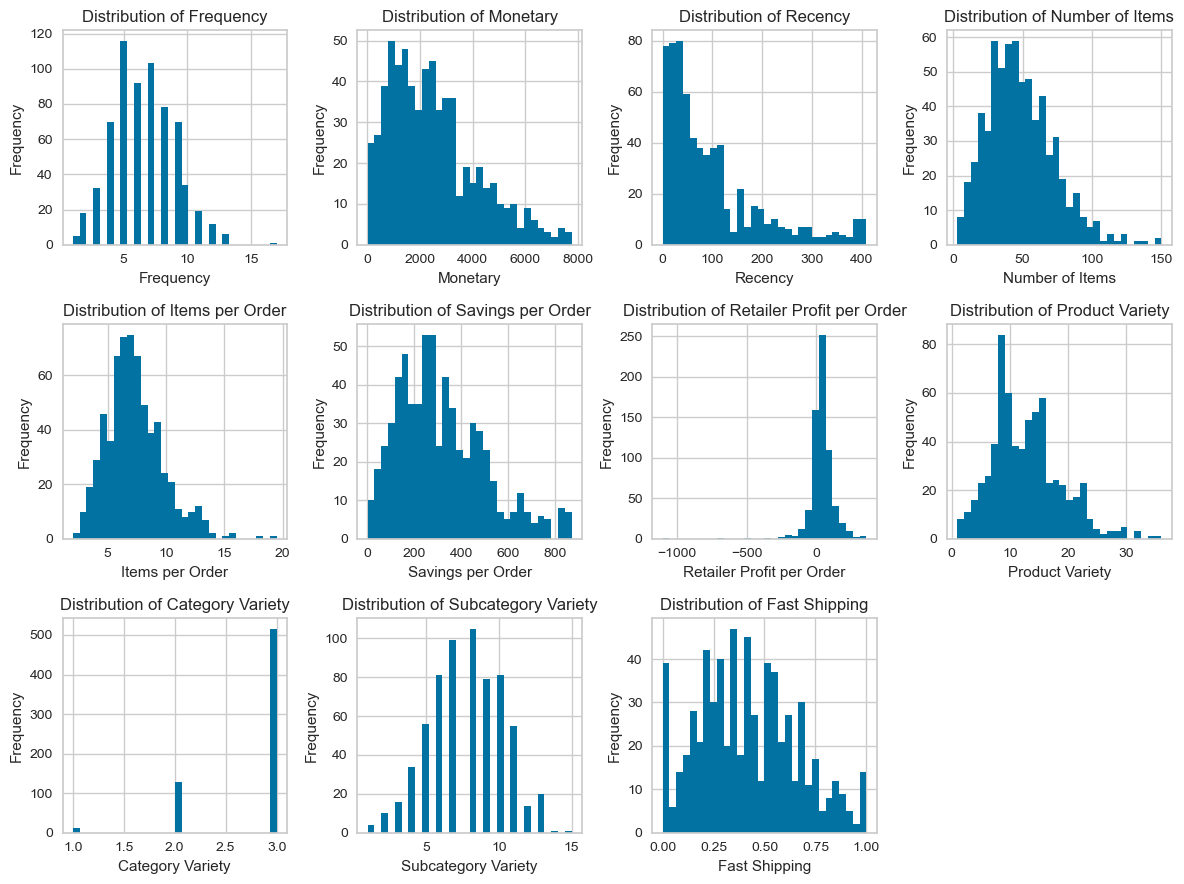

In [142]:
fig = plt.figure(figsize=(12, 9))
for i, feature in enumerate(customers_processed.columns):
    plt.subplot(3, 4, i+1)
    plt.hist(customers_processed[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
fig.tight_layout()

<Axes: >

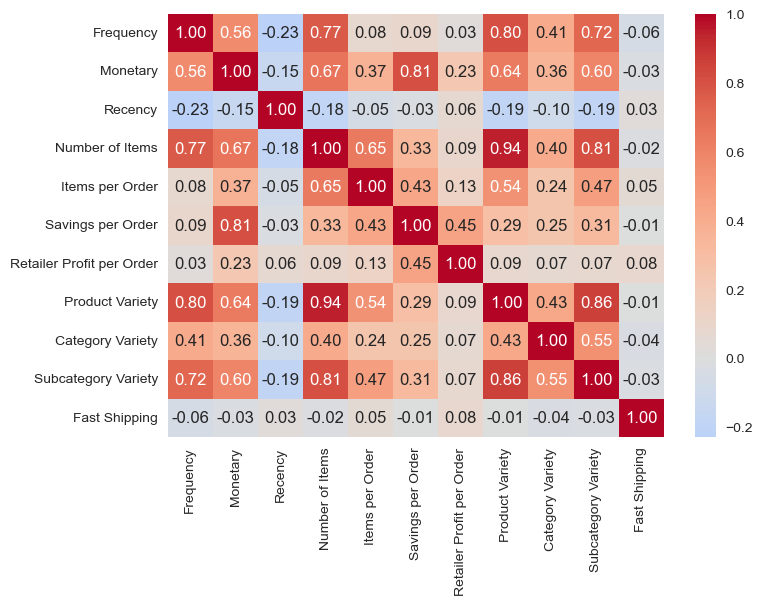

In [143]:
sns.heatmap(customers_processed.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')

Correlation between variables. Based on the low correlations to other features, I dropped Retailer Profit per Order and Fast Shipping. I also dropped Category Variety because it had only three possible values, and Number of Items since having all three of Number of Items, Items per Order, and Frequency (number of orders) would introduce multicollinearity.

In [144]:
customers_processed.drop(['Fast Shipping', 'Retailer Profit per Order', 'Number of Items', 'Category Variety'], axis=1, inplace=True)

In [145]:
scaler = StandardScaler()
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_processed), index=customers_processed.index, columns=customers_processed.columns)

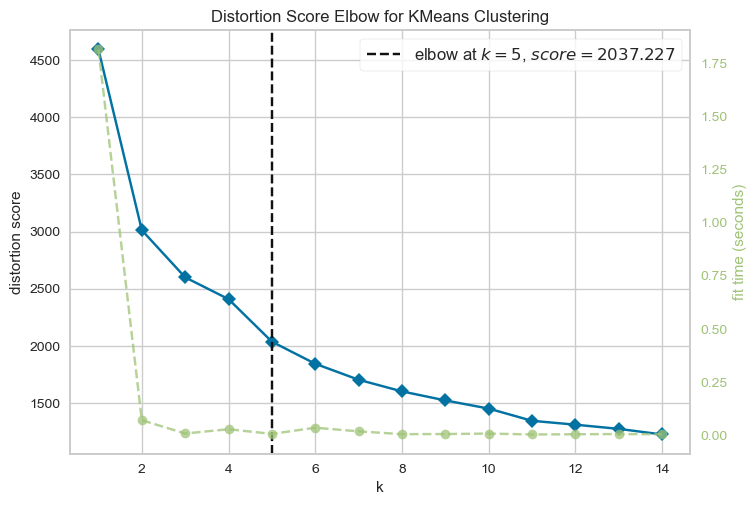

In [146]:
kmeans_model = KMeans(random_state=random_state)
visualizer = KElbowVisualizer(kmeans_model, k=(1, 15))
visualizer.fit(customers_scaled)
visualizer.show()
plt.show()

Silhouette scores:
K = 2: 0.2936
K = 3: 0.2078
K = 4: 0.1593
K = 5: 0.1993
K = 6: 0.1948
K = 7: 0.1964
K = 8: 0.1791
K = 9: 0.1813


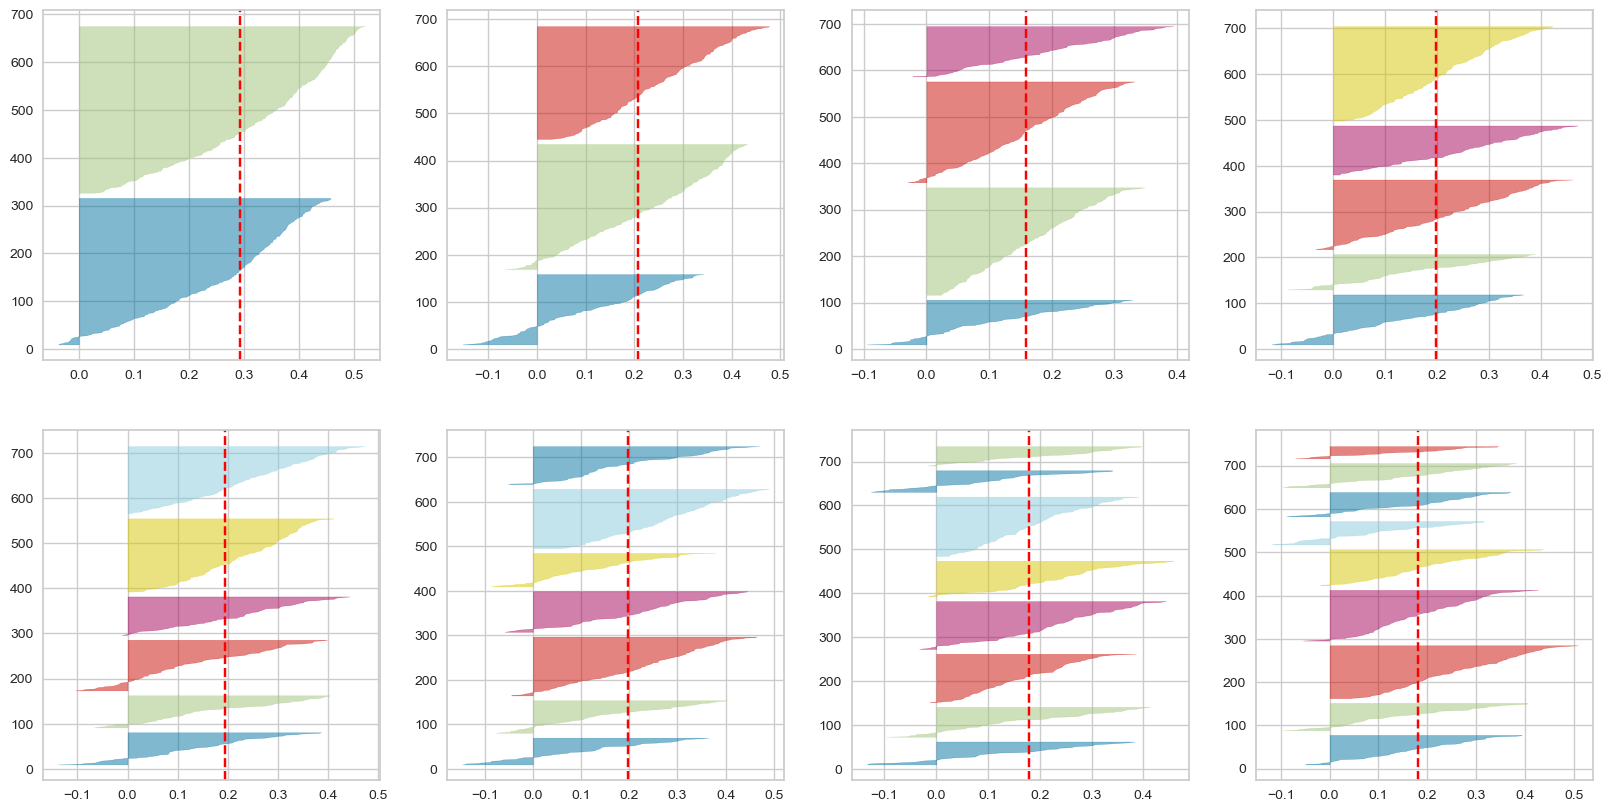

In [147]:
print("Silhouette scores:")
fig, ax = plt.subplots(2, 4, figsize=(20,10))
for i in range(2,10):
    km_i = KMeans(n_clusters=i, random_state=random_state)
    q, mod = divmod(i-2, 4)
    visualizer = SilhouetteVisualizer(km_i, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(customers_scaled)
    print(f"K = {i}: {visualizer.silhouette_score_:.4f}")

Although the point marked as the "elbow" by the yellowbrick visualizer was K=5, the highest silhouette score was obtained with K=2. However, the distortion score for K=2 was high compared to all other values, so I chose K=5 (which had a comparable score to K=3, 6, and 7).

In [148]:
km_model = KMeans(n_clusters=5, random_state=random_state)
km = km_model.fit_predict(customers_scaled)

# coordinates of cluster center
centroids = km_model.cluster_centers_

# cluster label for each data point
labels = km_model.labels_

In [149]:
customers_labeled = customers_scaled.copy()
customers_labeled['cluster'] = labels
customers_labeled['cluster'].value_counts()

cluster
4    207
2    153
0    110
3    108
1     78
Name: count, dtype: int64

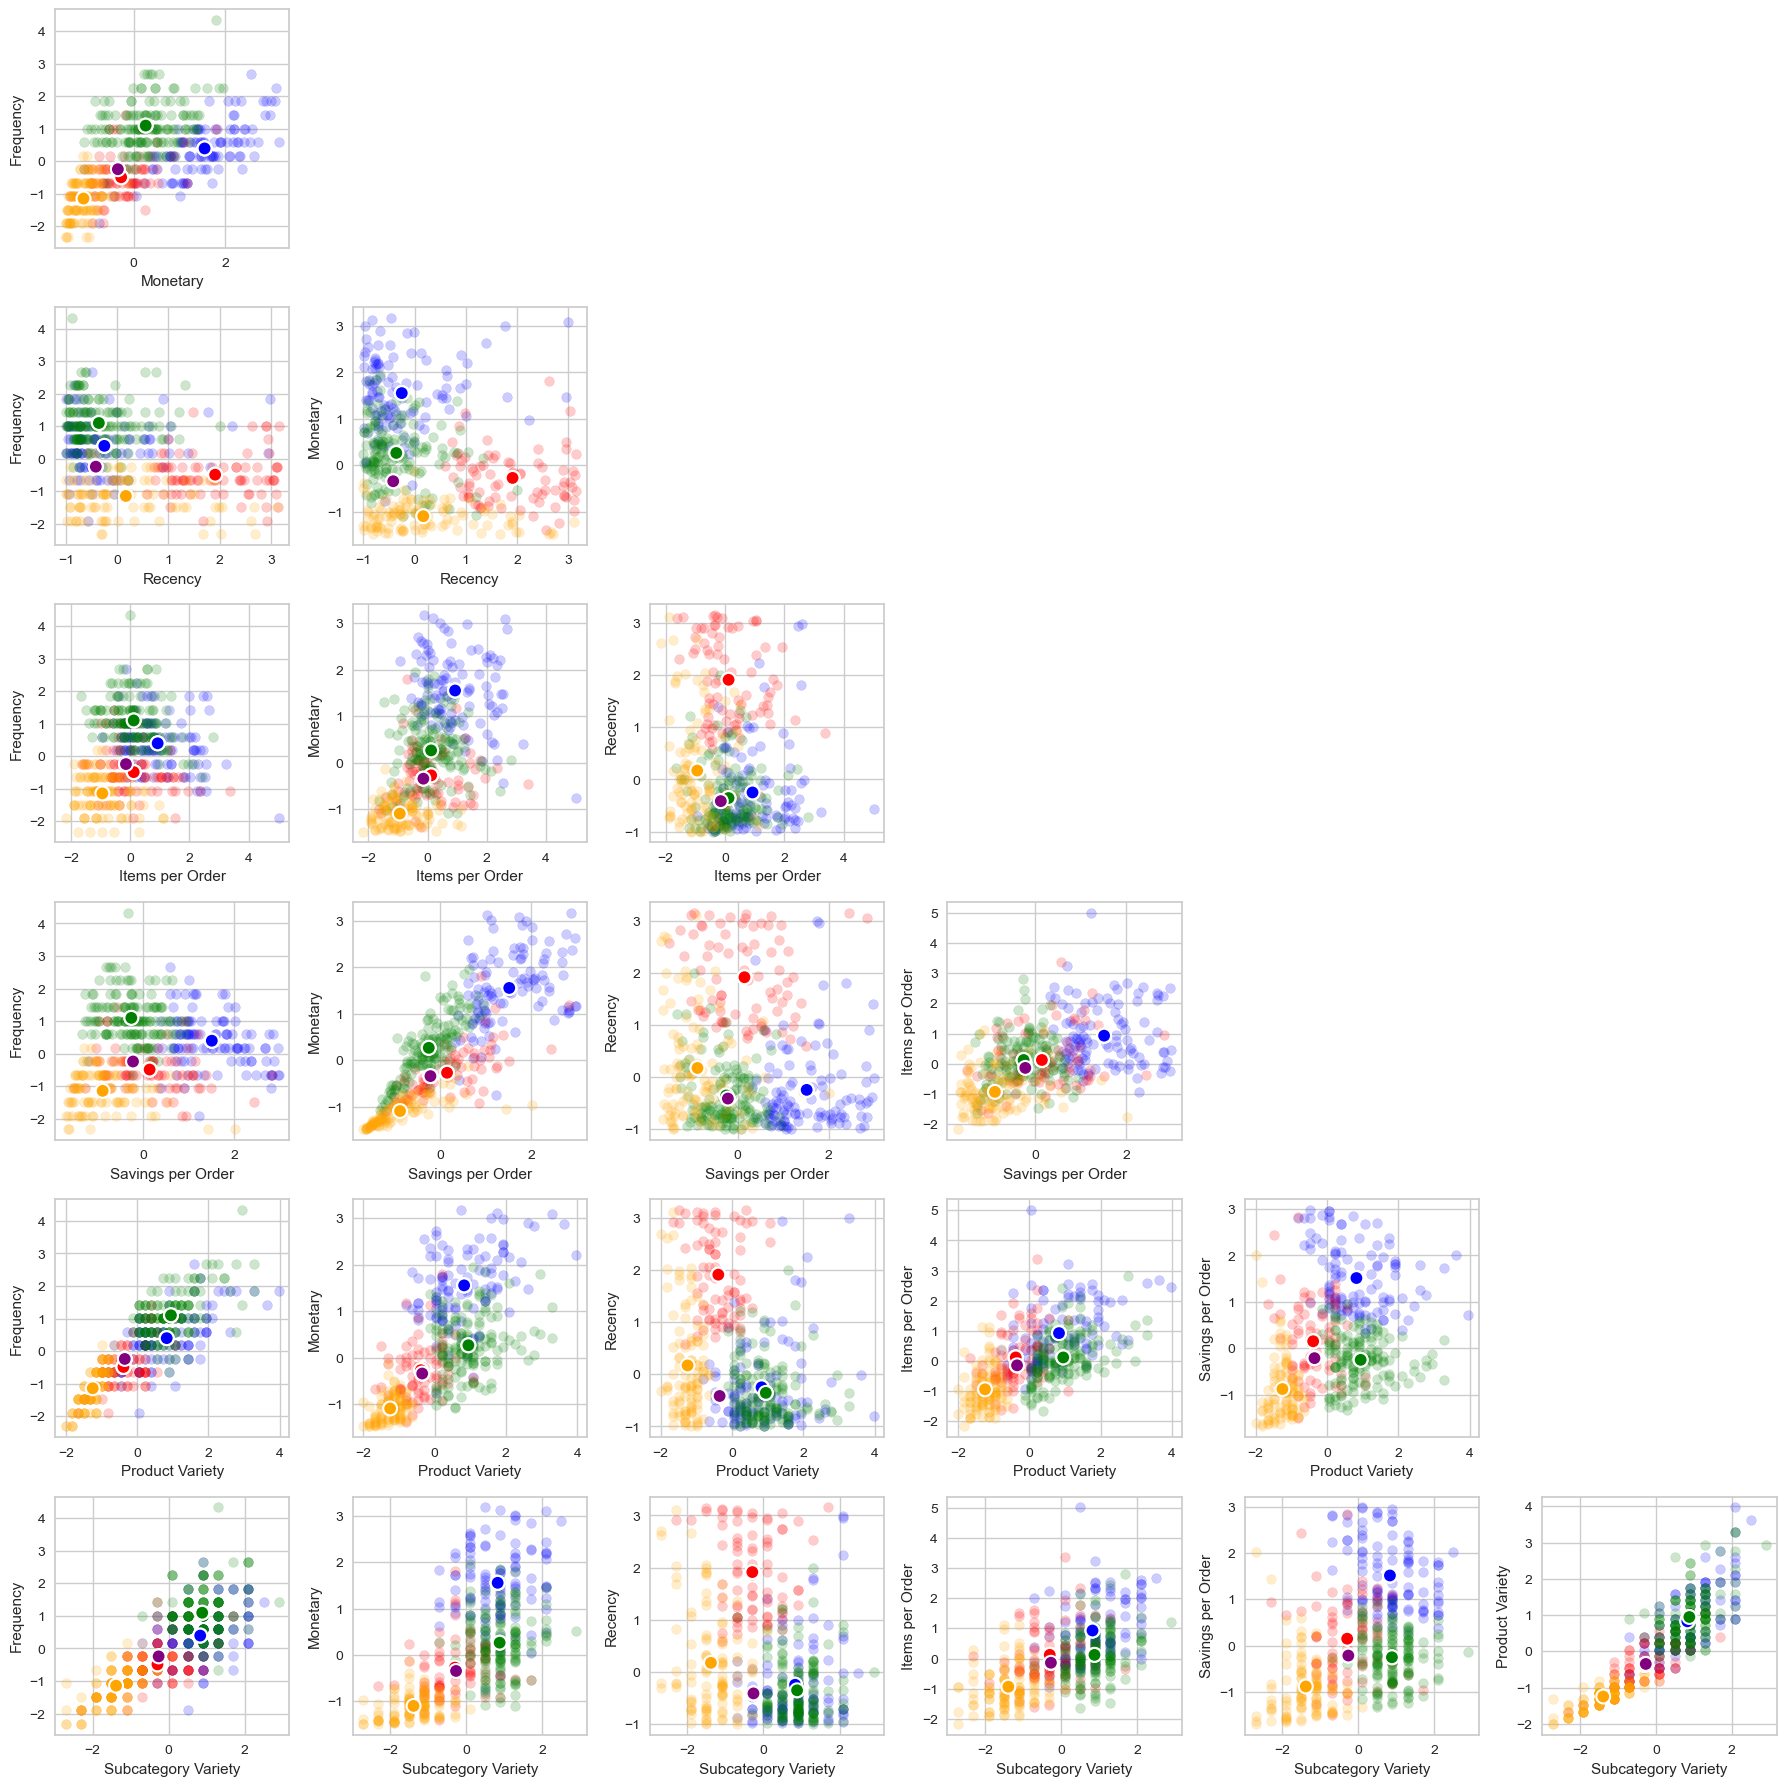

In [150]:
# Plot each combination of features against each other to see how the clusters differ
fig = plt.figure(figsize=(21, 21))
for i, feature_i in enumerate(customers_processed.columns):
  for j, feature_j in enumerate(customers_processed.columns):
    if j < i:
      plt.subplot(7, 7, 7*i + j + 1)
      colors = ['blue', 'red', 'green', 'orange', 'purple']
      for cluster in range(4):
        mask = customers_labeled['cluster'] == cluster
        plt.scatter(customers_labeled[mask][feature_i], customers_labeled[mask][feature_j],
               c=colors[cluster], alpha=0.2, label=cluster)
        plt.scatter(centroids[:, i], centroids[:, j], s=100, marker='o', c=colors, edgecolor='white', linewidths=1.5, label='centroids')
      plt.xlabel(feature_i)
      plt.ylabel(feature_j)
fig.tight_layout()

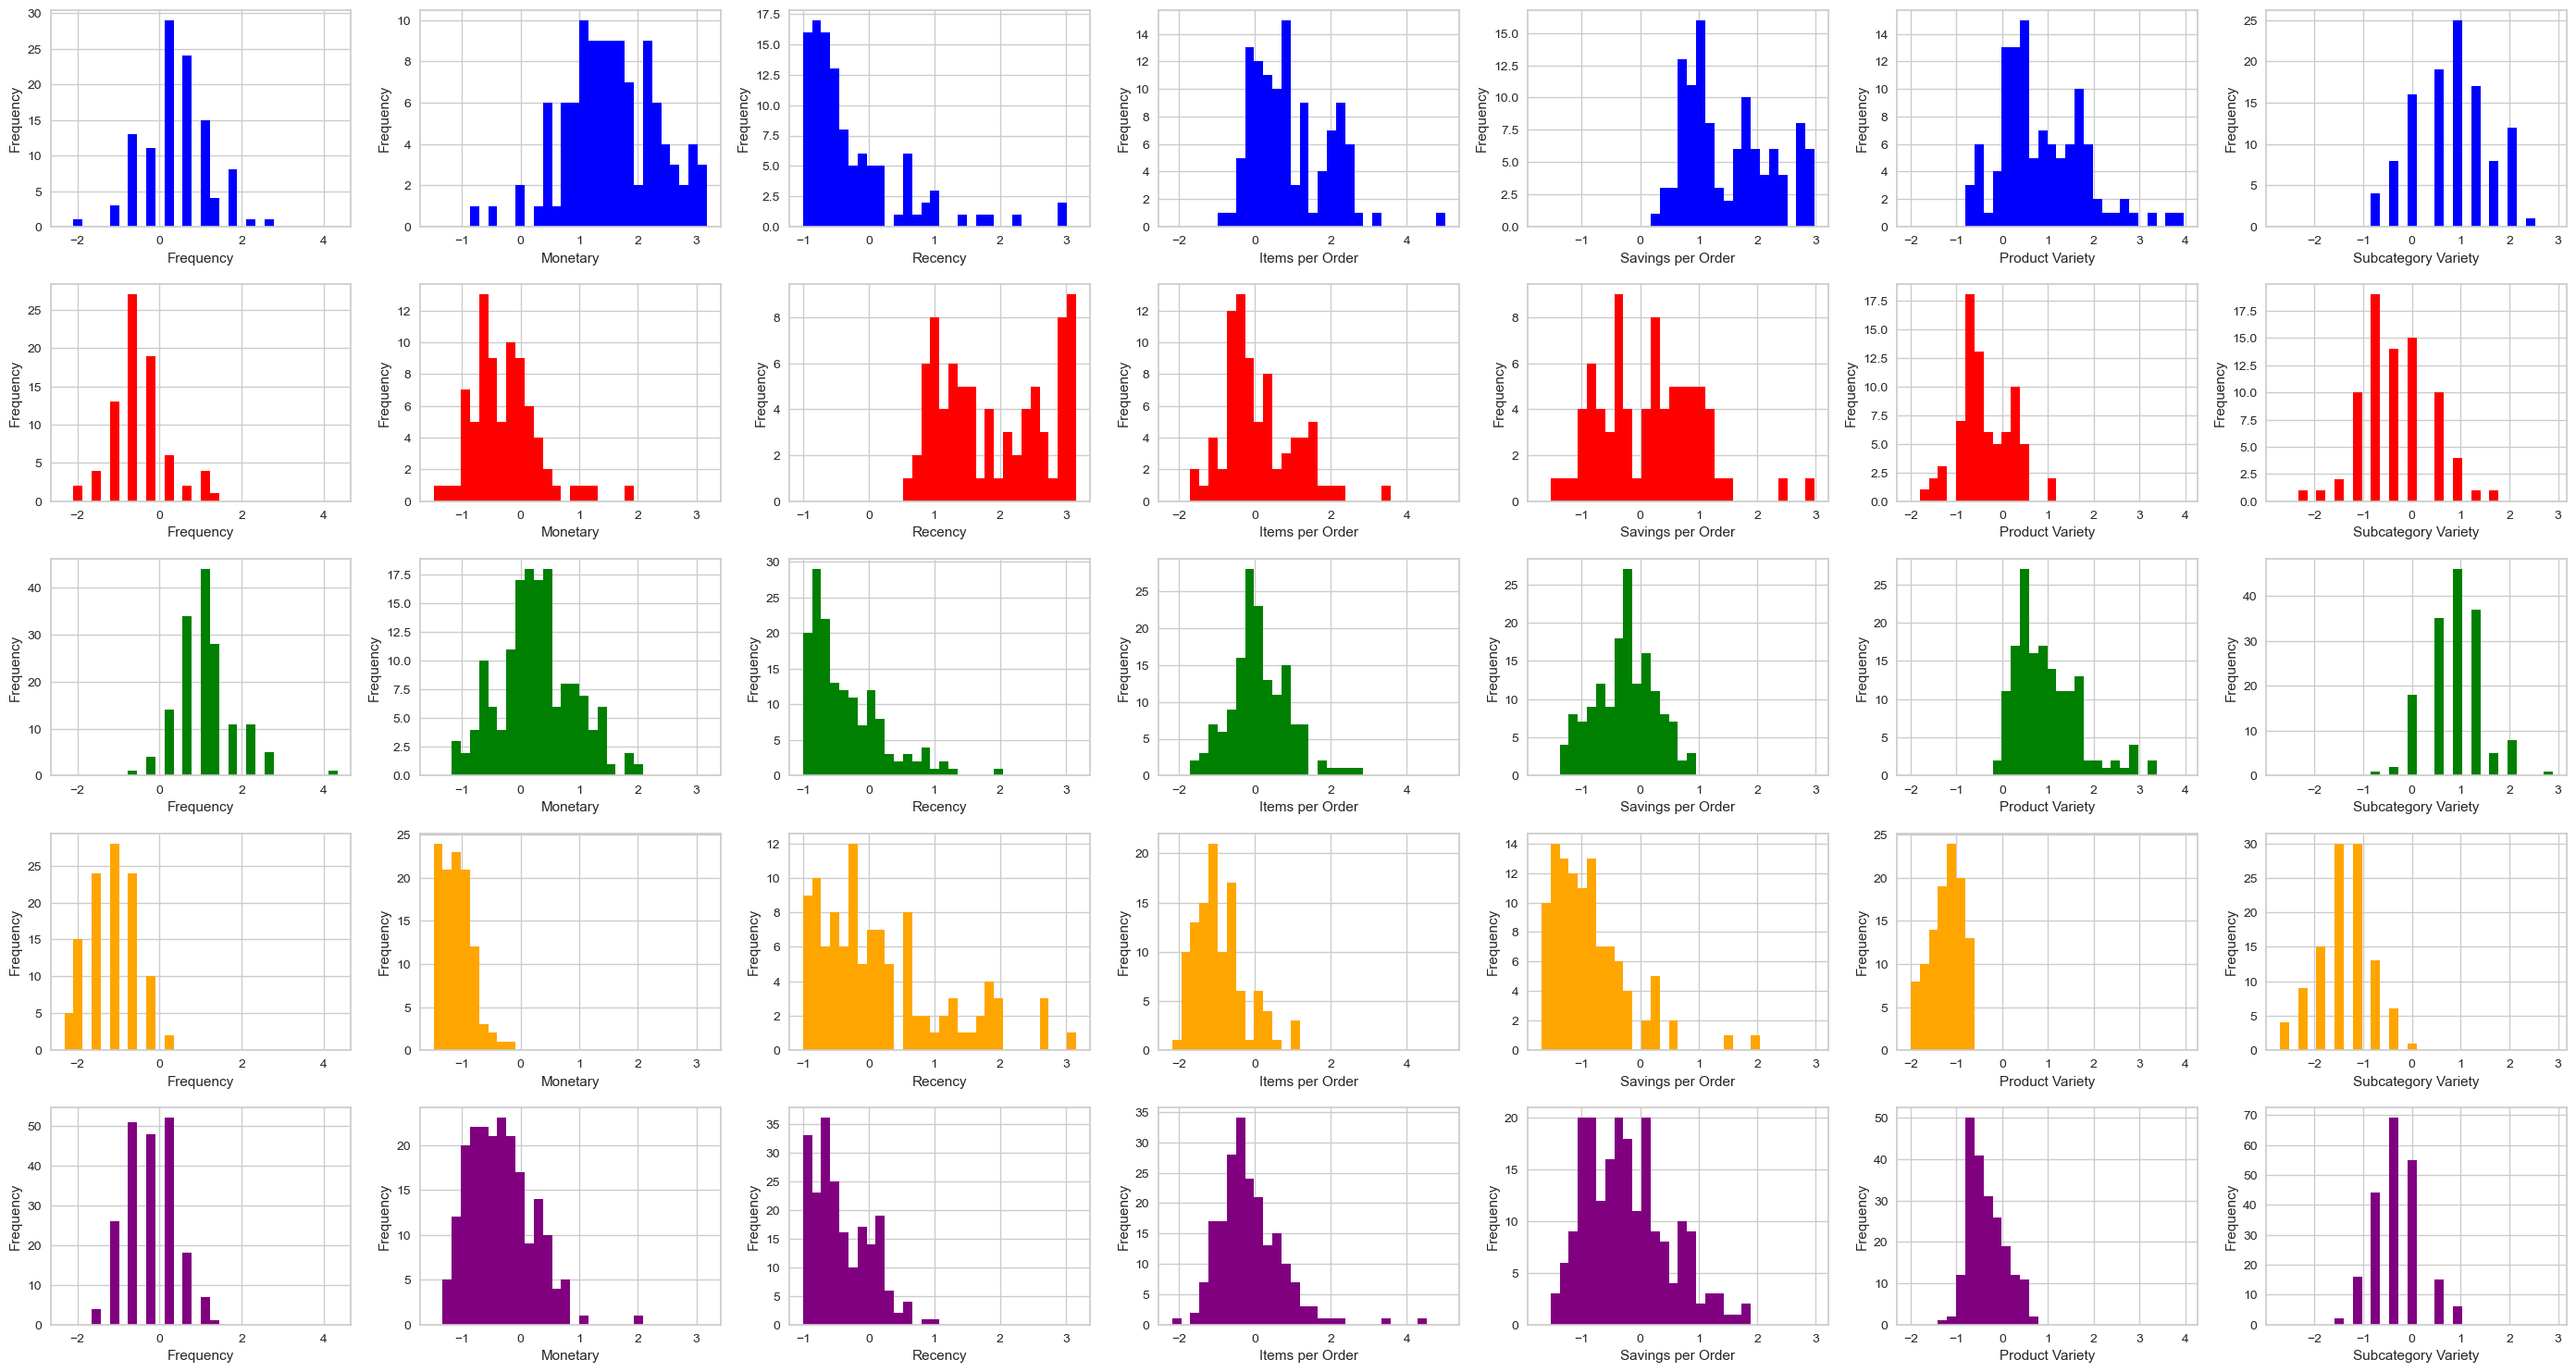

In [151]:
# Histograms of individual features
fig = plt.figure(figsize=(28, 15))
for i, feature in enumerate(customers_processed.columns):
    for cluster in range(5):
      #print(f'{feature} {cluster}')
      plt.subplot(5, 7, 7*cluster + i+1)
      mask = customers_labeled['cluster'] == cluster
      plt.hist(customers_labeled[mask][feature], bins=30, color=colors[cluster], range=(customers_labeled[feature].min(),customers_labeled[feature].max()))
      plt.xlabel(feature)
      plt.ylabel('Frequency')
fig.tight_layout()

Clusters 1, 3, and 4 are similar on most attributes, but cluster 1 contains customers who have not made a purchase in a long time, while customers in clusters 3 and 4 are also below-average spenders but have made a purchase more recently. Cluster 3 is worse than cluster 4 on some metrics, but I would consider both to be fairly disengaged customers.

Cluster 0 contains the highest spenders, who buy a higher number and variety of items. While they spend the most, they also take advantage of discounts more than other customers.

Cluster 2 customers are average spenders, and place orders with above-average frequency and product variety but order fewer items at a time than cluster 0.

## Agglomerative Clustering

In [152]:
agg_cluster = AgglomerativeClustering(n_clusters=None, metric='euclidean', linkage='ward', compute_full_tree=True, distance_threshold=25)

# Cluster the data
agg_clusters = agg_cluster.fit_predict(customers_scaled)

print(f"Number of clusters = {1+np.amax(agg_cluster.labels_)}")

agg_labels = agg_cluster.labels_
customers_labeled['agg_cluster'] = agg_labels
customers_labeled['agg_cluster'].value_counts()

Number of clusters = 4


agg_cluster
1    242
3    206
0    113
2     95
Name: count, dtype: int64

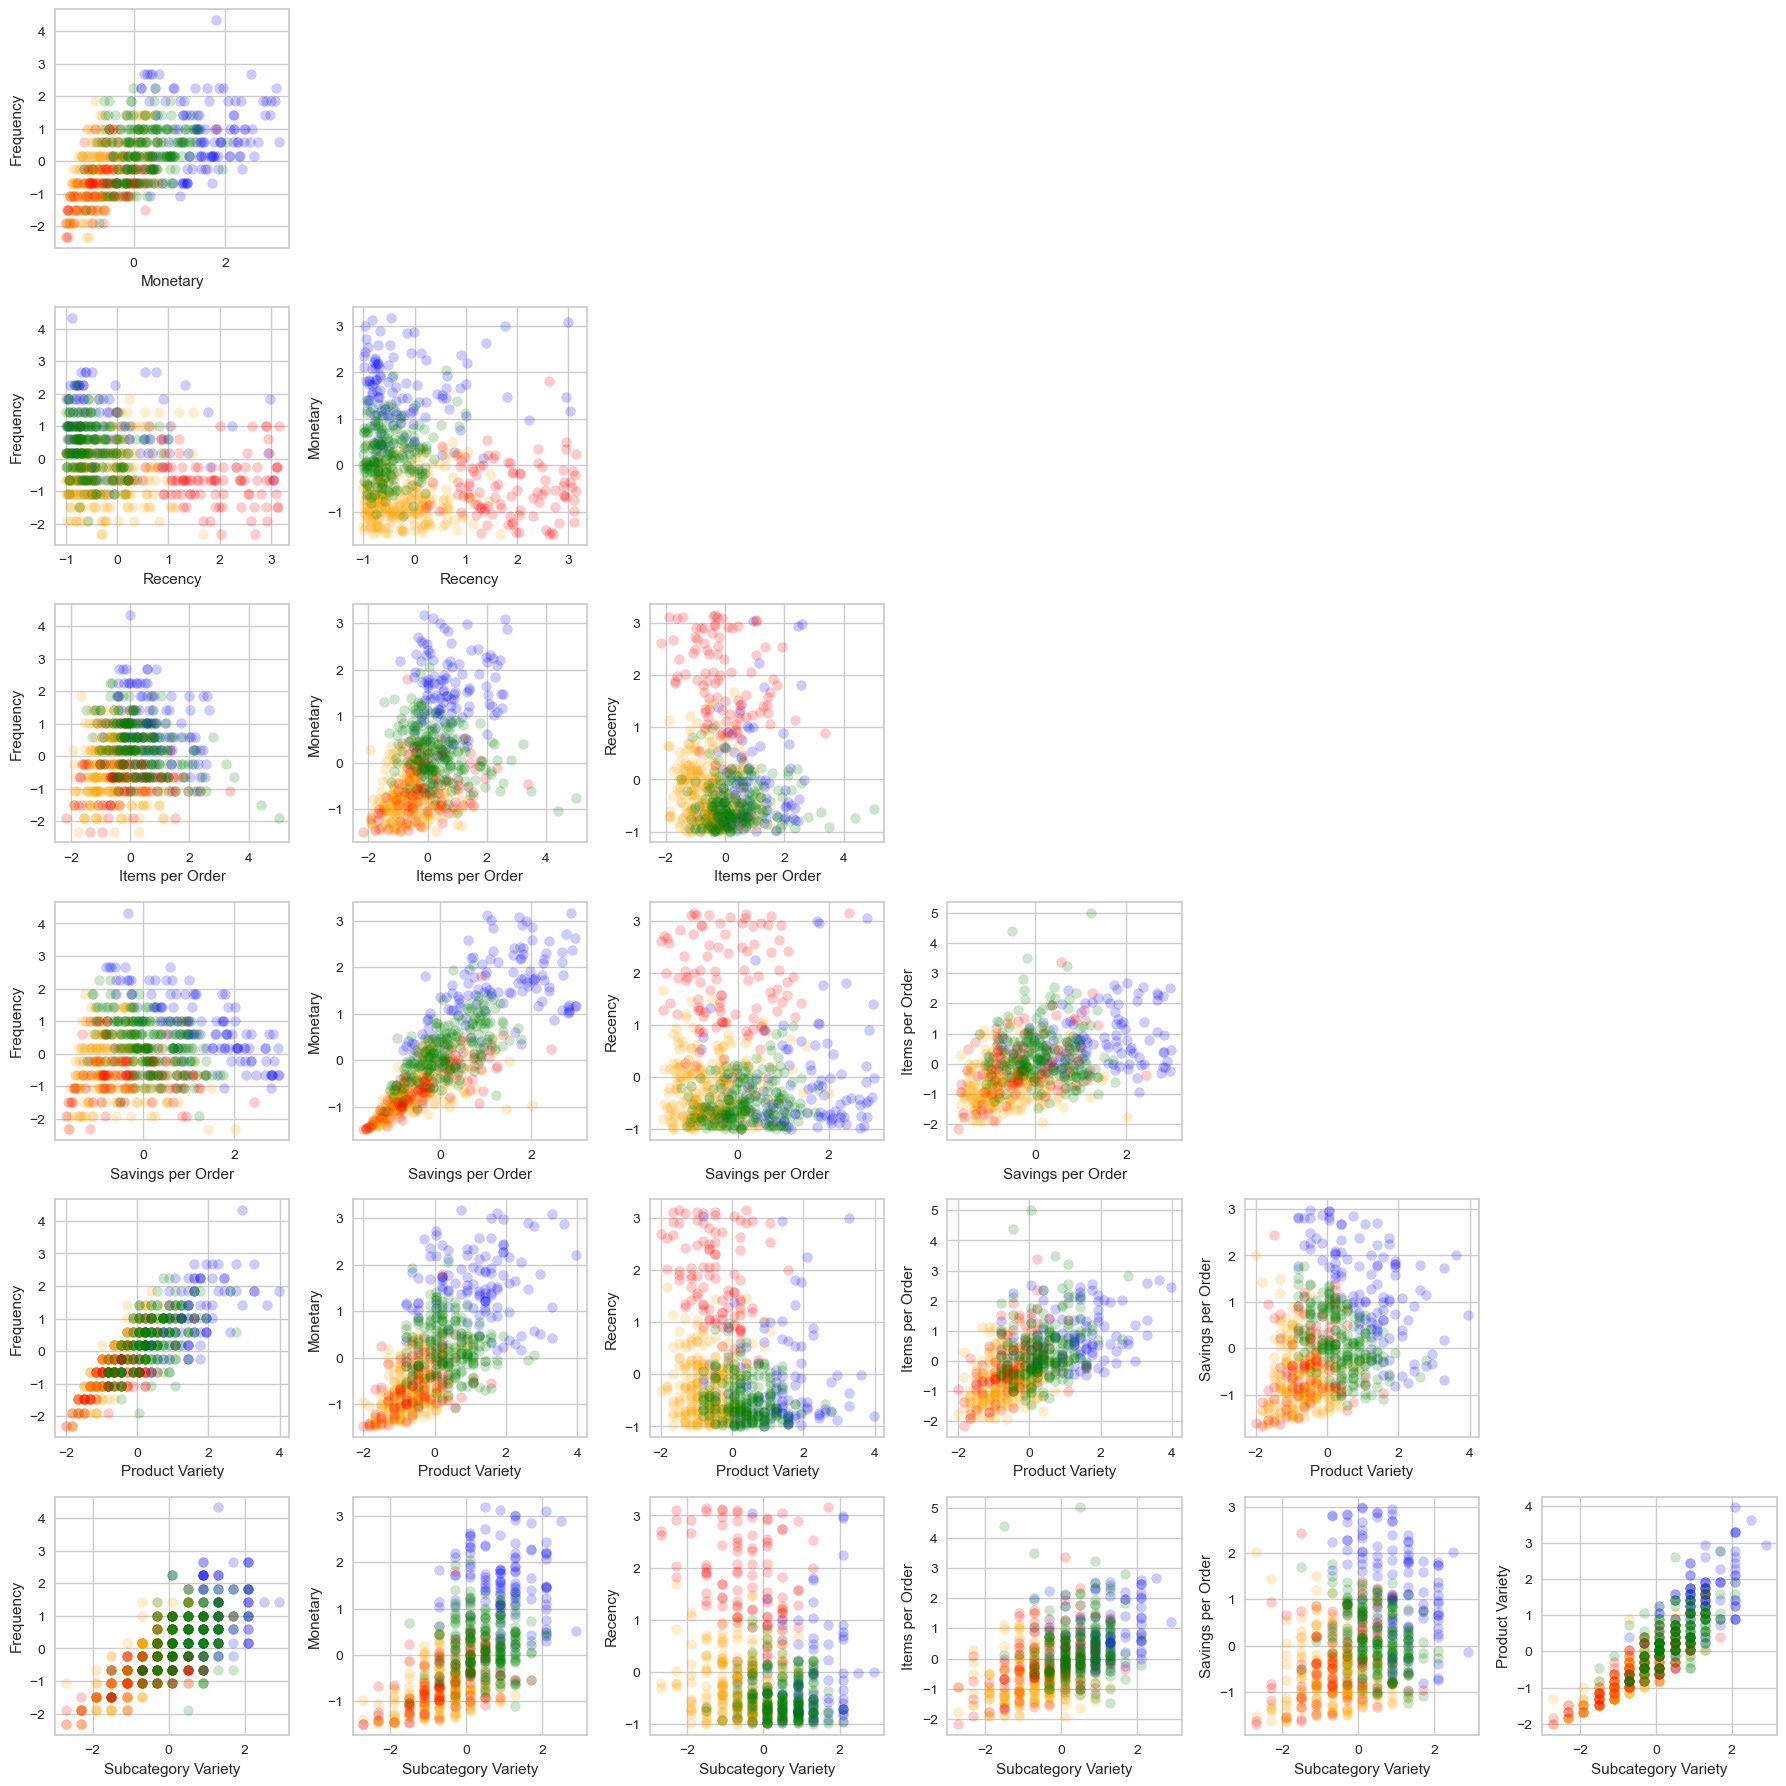

In [153]:
# Plot each combination of features against each other to see how the clusters differ
fig = plt.figure(figsize=(21, 21))
for i, feature_i in enumerate(customers_processed.columns):
  for j, feature_j in enumerate(customers_processed.columns):
    if j < i:
      plt.subplot(7, 7, 7*i + j + 1)
      colors = ['blue',  'orange','red', 'green']
      for cluster in range(4):
        mask = customers_labeled['agg_cluster'] == cluster
        plt.scatter(customers_labeled[mask][feature_i], customers_labeled[mask][feature_j],
               c=colors[cluster], alpha=0.2, label=cluster)
      plt.xlabel(feature_i)
      plt.ylabel(feature_j)
fig.tight_layout()

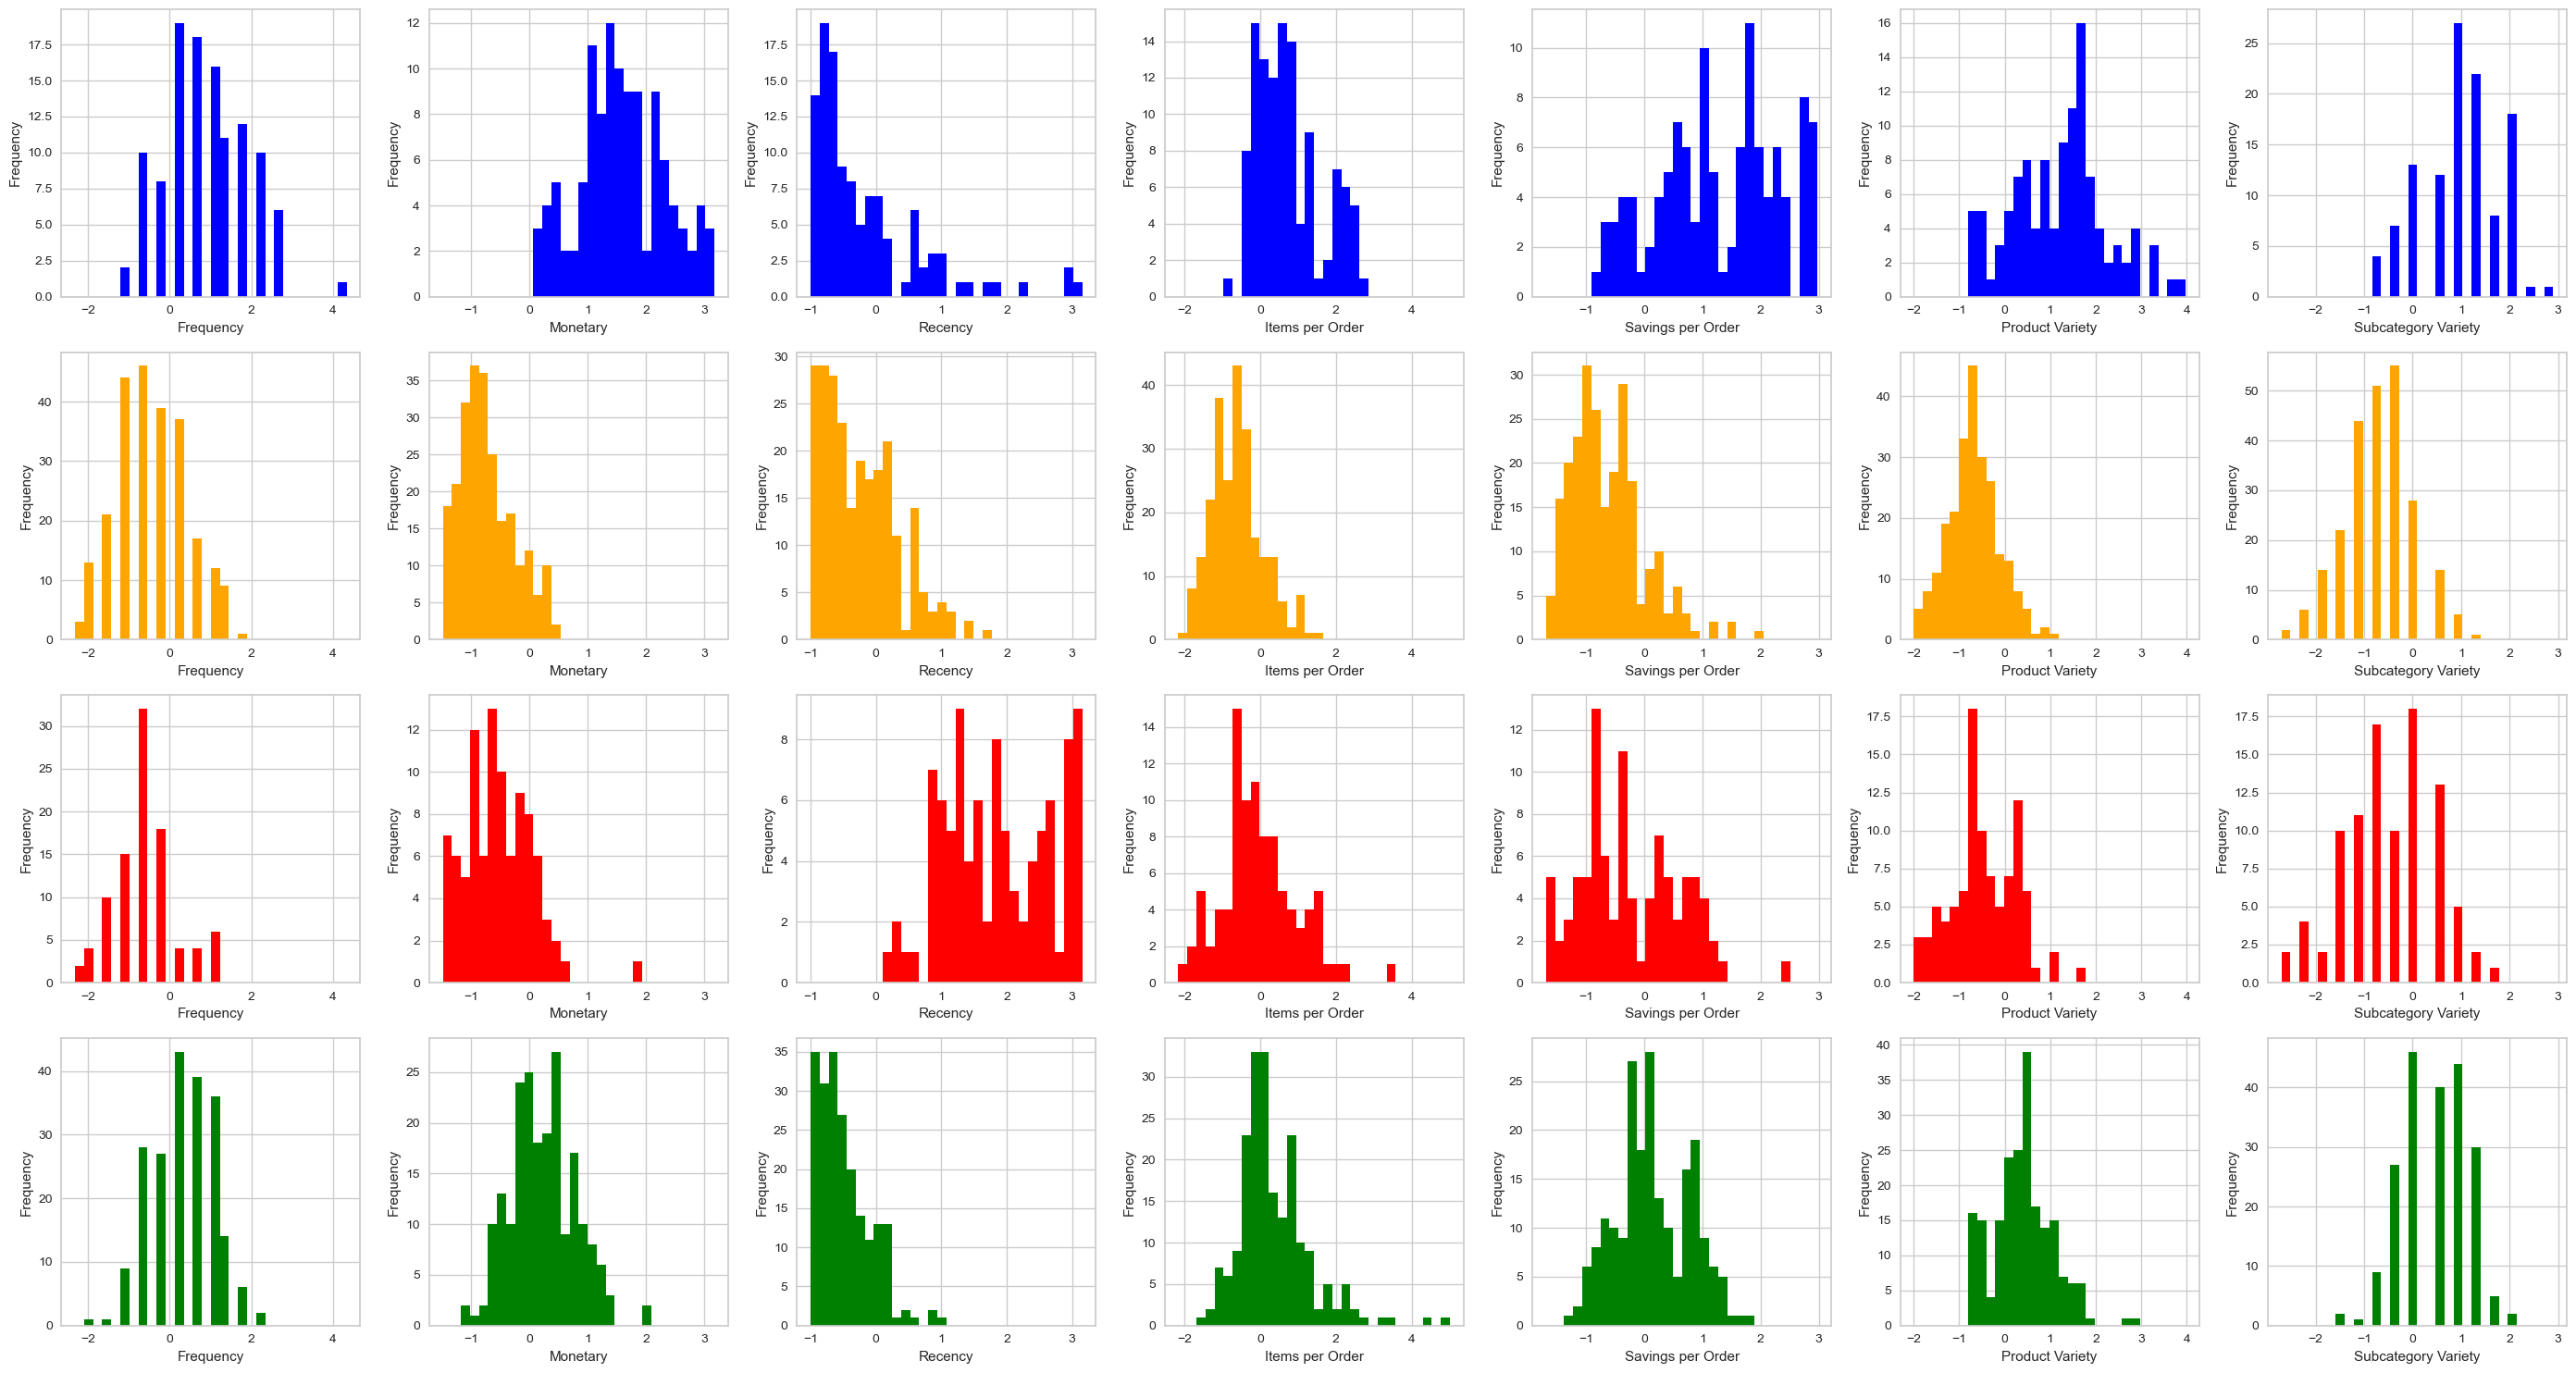

In [154]:
fig = plt.figure(figsize=(28, 15))
for i, feature in enumerate(customers_processed.columns):
    for cluster in range(4):
      #print(f'{feature} {cluster}')
      plt.subplot(4, 7, 7*cluster + i+1)
      mask = customers_labeled['agg_cluster'] == cluster
      plt.hist(customers_labeled[mask][feature], bins=30, color=colors[cluster], range=(customers_labeled[feature].min(),customers_labeled[feature].max()))
      plt.xlabel(feature)
      plt.ylabel('Frequency')
fig.tight_layout()

In [155]:
from sklearn.metrics import adjusted_rand_score
similarity = adjusted_rand_score(km, agg_clusters)
print(f"\nSimilarity between K-Means and Agglomerative Clustering: {similarity:.3f}")


Similarity between K-Means and Agglomerative Clustering: 0.323


I found the clusters created by this algorithm to be the most interpretable, and chose to implement them in the Streamlit app.

*   Blue cluster: Tend to spend more money in total and order a larger quantity of items at a time. On the lookout for deals (the customers farthest above average on savings per order are in this category). In the Streamlit app, I referred to this cluster as "Bulk Buyers."
*   Orange cluster: Average frequency, below-average items per order and item variety. Spending is a bit below average. In the Streamlit app, this cluster is referred to as "At Risk".
*   Red cluster: Few purchases, tend to buy only one or two items at a time. Have not made a purchase in quite a while -- least engaged customer group. In the Streamlit app, this cluster is referred to as "Disengaged".
*   Green cluster: Slightly above-average frequency, spending, variety. "Engaged" customers, but not top spenders.

### Circle plot using code provided in lecture notebook

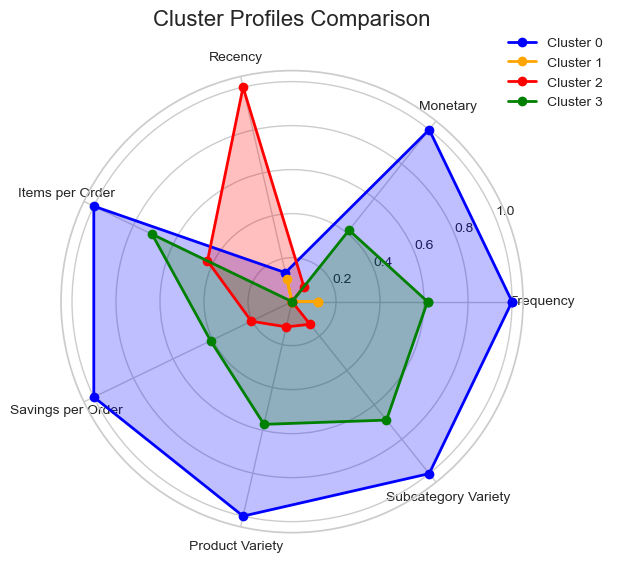

In [156]:
# Calculate cluster profiles
cluster_profiles = customers_labeled.groupby('agg_cluster')[customers_processed.columns].mean().round(2)

# Normalize cluster profiles for radar chart
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Set up radar chart
categories = customers_processed.columns
fig = plt.figure(figsize=(6, 6))

# Number of variables
num_vars = len(categories)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the plot
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories)

# Plot each cluster
for idx, row in cluster_profiles_normalized.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {idx}', color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title('Cluster Profiles Comparison', size=16, y=1.08)
plt.show()

In [157]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
customers_pca = pca.fit_transform(customers_scaled)
print(pd.DataFrame(pca.components_, columns=customers_scaled.columns))
# Component 1: Everything except recency
# Component 2: Mainly savings, items per order, recency
# Component 3: Recency
print(pca.explained_variance_ratio_)

   Frequency  Monetary   Recency  Items per Order  Savings per Order  \
0   0.394782  0.444611 -0.134087         0.304663           0.305398   
1  -0.468177  0.257990  0.343993         0.361342           0.623362   
2   0.145591 -0.148346  0.900636         0.083704          -0.253605   

   Product Variety  Subcategory Variety  
0         0.478843             0.461639  
1        -0.205049            -0.186351  
2         0.203736             0.181168  
[0.52376521 0.18734874 0.12988535]


## HDBSCAN

In [158]:
print("HDBSCAN clusters:")
for i in range(2,10):
  hdb = HDBSCAN(min_cluster_size=i).fit(customers_scaled)
  hdb_labels = hdb.labels_
  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
  n_noise_ = list(hdb_labels).count(-1)
  print(f"Min cluster size {i}: estimated # clusters {n_clusters_}, estimated # noise points: {n_noise_}")

hdb = HDBSCAN(min_cluster_size=3).fit(customers_scaled)
hdb_labels = hdb.labels_
customers_labeled['hdb_cluster'] = hdb_labels
print("\nHDBSCAN clusters (min cluster size 3, 2 clusters)")
print(customers_labeled['hdb_cluster'].value_counts())

HDBSCAN clusters:
Min cluster size 2: estimated # clusters 169, estimated # noise points: 187
Min cluster size 3: estimated # clusters 2, estimated # noise points: 35
Min cluster size 4: estimated # clusters 3, estimated # noise points: 152
Min cluster size 5: estimated # clusters 3, estimated # noise points: 381
Min cluster size 6: estimated # clusters 2, estimated # noise points: 392
Min cluster size 7: estimated # clusters 2, estimated # noise points: 630
Min cluster size 8: estimated # clusters 2, estimated # noise points: 511
Min cluster size 9: estimated # clusters 0, estimated # noise points: 656

HDBSCAN clusters (min cluster size 3, 2 clusters)
hdb_cluster
 0    618
-1     35
 1      3
Name: count, dtype: int64


Examining the label distribution for the two-cluster HDBSCAN solution, which minimizes the number of points classified as noise (minimum cluster size of 3), it lumps almost all the data points into one cluster, making these labels less useful for customer segmentation.

## Gaussian Mixture Model

Code taken from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

In [159]:
# Code from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(customers_scaled)

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
18,1,full,2001.941933
6,1,tied,2001.941933
7,2,tied,2002.070929
8,3,tied,2024.604408
9,4,tied,2040.275978


In [160]:
gmm = GaussianMixture(n_components = 3, covariance_type='full')
gmm_labels = gmm.fit_predict(customers_scaled)
customers_labeled['gmm_cluster'] = gmm_labels
customers_labeled['gmm_cluster'].value_counts()

gmm_cluster
0    249
2    229
1    178
Name: count, dtype: int64

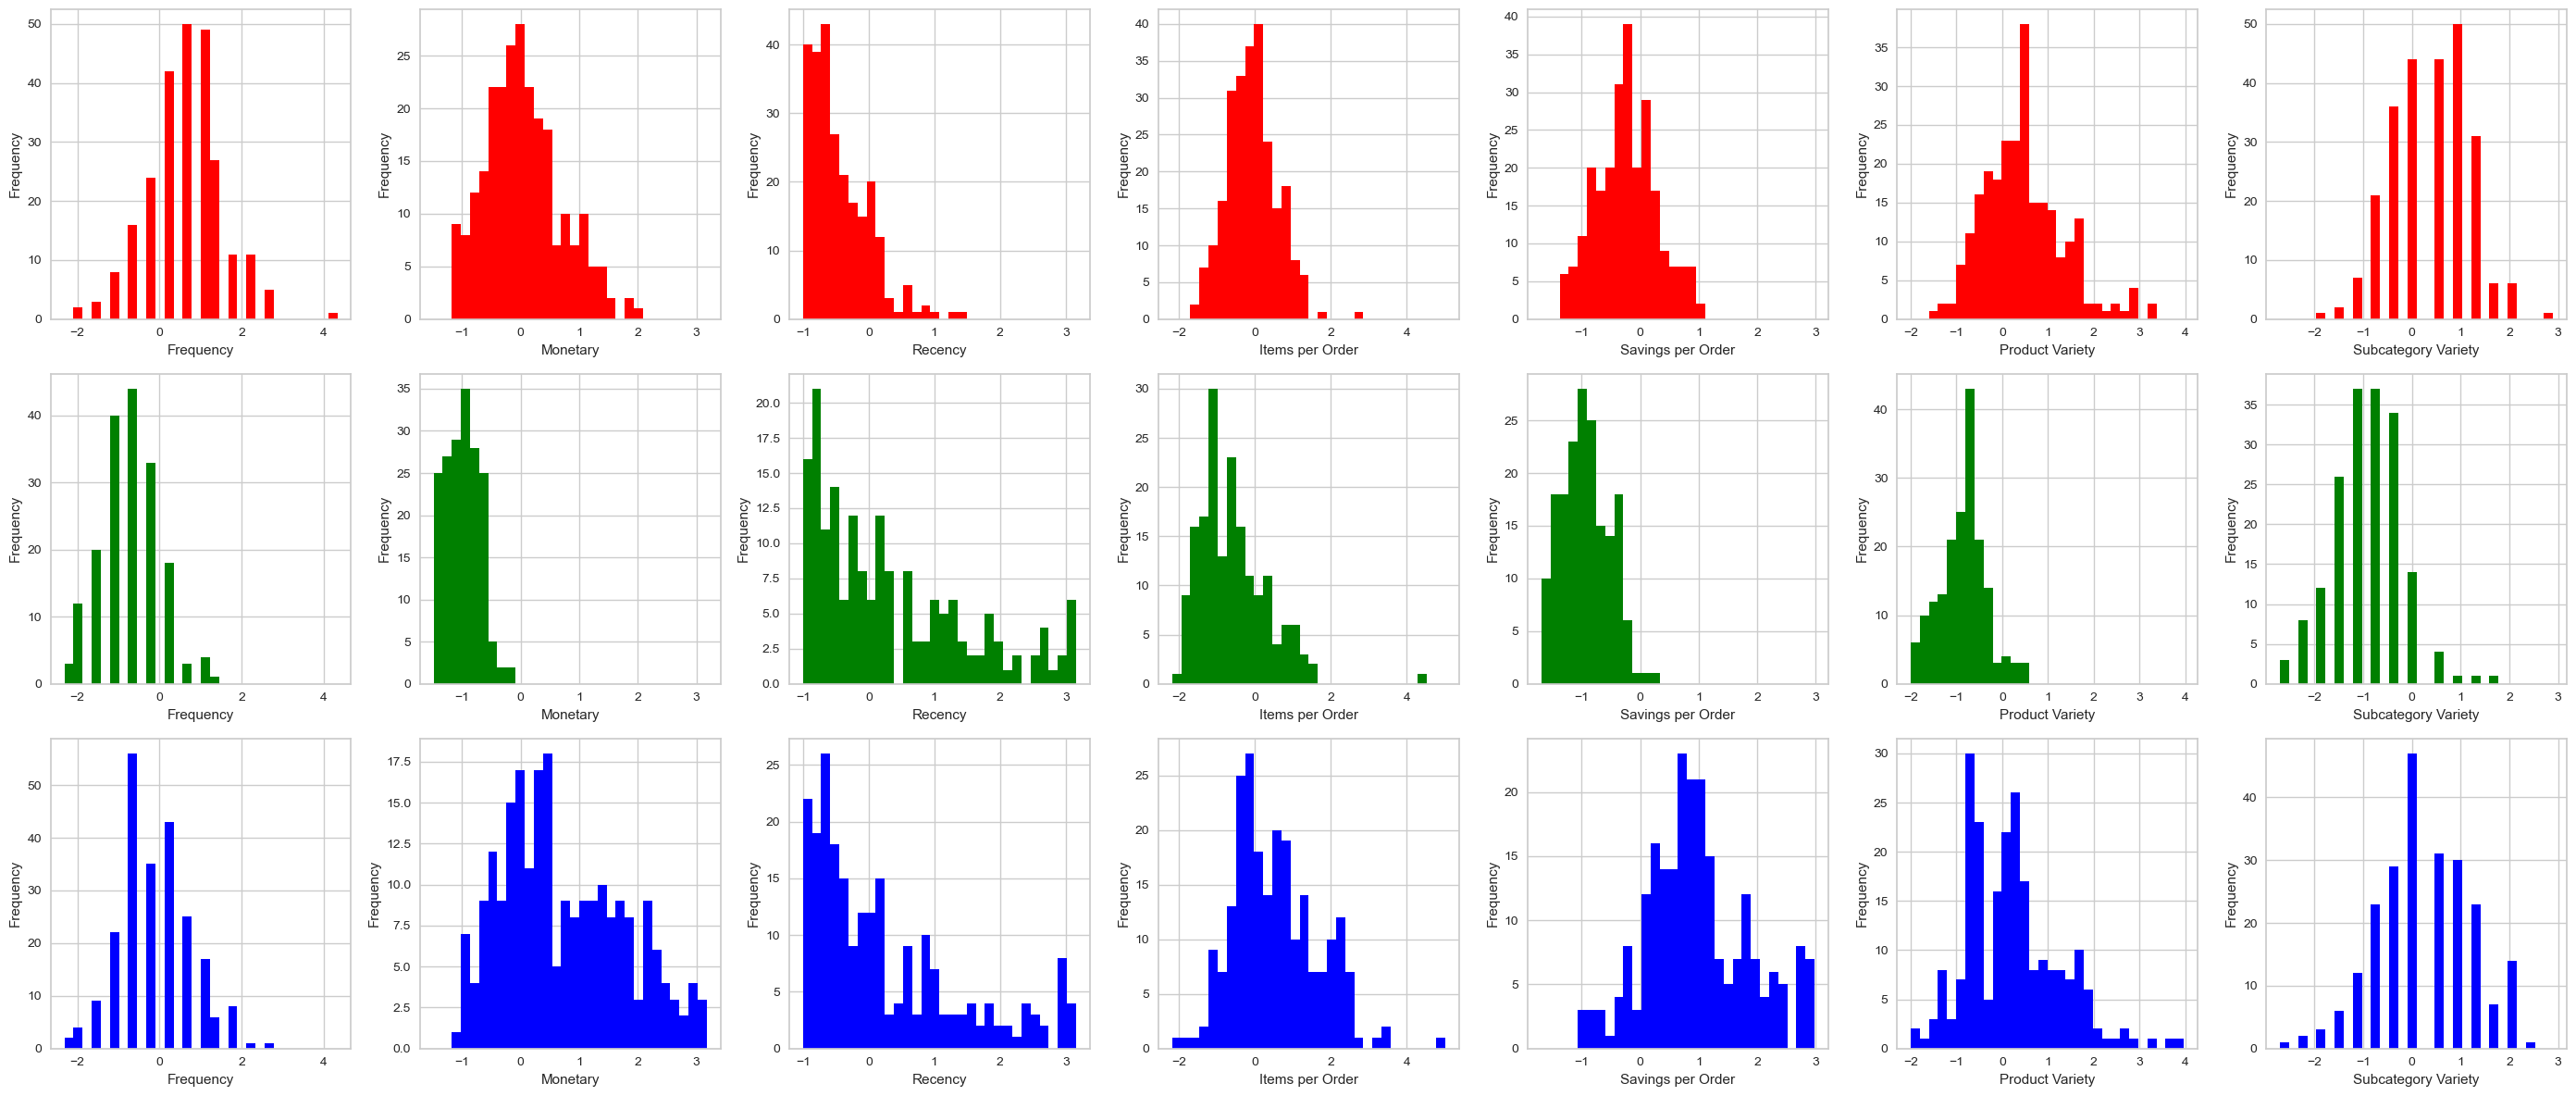

In [161]:
gmm_colors = ['red', 'green', 'blue']
fig = plt.figure(figsize=(28, 12))
for i, feature in enumerate(customers_processed.columns):
    for cluster in range(3):
      #print(f'{feature} {cluster}')
      plt.subplot(3, 7, 7*cluster + i+1)
      mask = customers_labeled['gmm_cluster'] == cluster
      plt.hist(customers_labeled[mask][feature], bins=30, color=gmm_colors[cluster], range=(customers_labeled[feature].min(),customers_labeled[feature].max()))
      plt.xlabel(feature)
      plt.ylabel('Frequency')
fig.tight_layout()

This method also identifies a cluster of high-spending, deal-seeking customers (colored as blue here to match the previous clustering) and one of less recent, low-spending/few-products customers (red). The third cluster (label 1, green) combines the green and orange clusters from the K-Means/Agglomerative clusterings into one group. Because these two clusters differed in spending (the green cluster spent notably more than orange) it seems useful for business purposes to use a clustering method that distinguishes between them.

I did a couple comparisons to variables that were in the original data set but not used as features (type of customer as one of Corporate, Consumer, and Home Office, and region of the US).

<Axes: xlabel='Segment'>

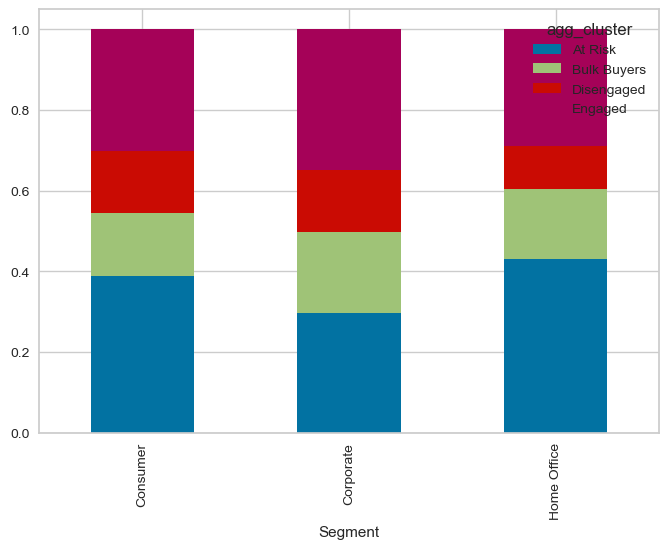

In [162]:
customers.set_index('Customer ID', inplace=True)
customers.loc[customers_processed.index, 'agg_cluster'] = agg_labels
customers.replace({'agg_cluster':{0:'Bulk Buyers', 1:'At Risk', 2:'Disengaged', 3:'Engaged'}}, inplace=True)
pd.crosstab(customers.loc[customers_processed.index, 'Segment'], customers.loc[customers_processed.index, 'agg_cluster'], normalize='index').plot(kind='bar', stacked=True)

<Axes: xlabel='Region'>

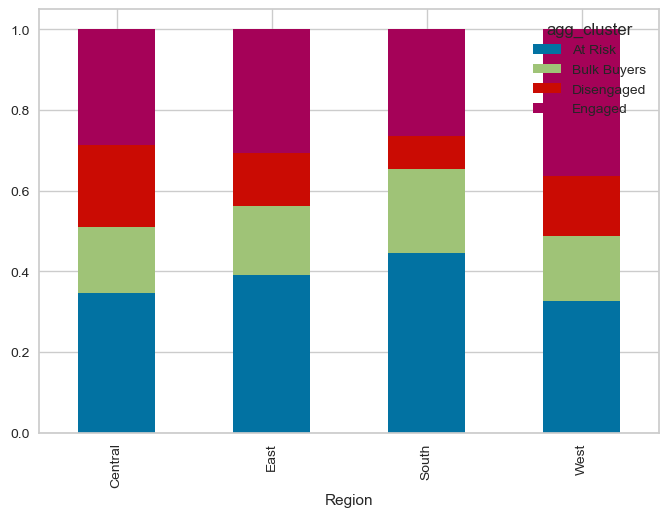

In [163]:
pd.crosstab(customers.loc[customers_processed.index, 'Region'], customers.loc[customers_processed.index, 'agg_cluster'], normalize='index').plot(kind='bar', stacked=True)

We can see that corporate customers are less likely to fall in the "At Risk" category, and more likely to fall in the highest-spending clusters of "Bulk Buyers" and "Loyal", but the differences are not huge -- all categories include customers who are disengaged or at risk. Similarly, there are small differences between regions, with the highest number of at-risk clients in the South and the highest number of disengaged customers in the Central region.

# Association Rule Mining

In [167]:
orders = purchases.merge(customers['agg_cluster'], how='left', left_on='Customer ID', right_index=True).groupby("Order ID").agg(
    {'Recency': 'first', 'Ship Mode':'first', 'Region': 'first', 'Product Name': list, 'Category':list, 'Subcategory':list,
     'Sales':'sum', 'Quantity':'sum', 'Customer Savings':'sum', 'Profit':'sum', 'Customer ID':'first', 'agg_cluster':'first'}
    ).reset_index()

te = TransactionEncoder()
products_encoded = pd.DataFrame(te.fit_transform(orders['Product Name']), columns=te.columns_)

In [168]:
products_encoded.sum(axis=0).sort_values(ascending=False)

Staples                                                                      222
Avery Non-Stick Binders                                                       20
KI Adjustable-Height Table                                                    18
Storex Dura Pro Binders                                                       17
Situations Contoured Folding Chairs 4/Set                                     15
                                                                            ... 
Konica Minolta magicolor 1690MF Multifunction Printer                          1
Xerox 1984                                                                     1
Cisco Desktop Collaboration Experience DX650 IP Video Phone                    1
Belkin 8 Outlet SurgeMaster II Gold Surge Protector with Phone Protection      1
Cisco SPA525G2 5-Line IP Phone                                                 1
Length: 1841, dtype: int64

In [169]:
print("Apriori")
print(apriori(products_encoded, min_support=0.01, use_colnames=True))
print("FP-Growth")
print(fpgrowth(products_encoded, min_support=0.01, use_colnames=True))

Apriori
   support   itemsets
0  0.04432  (Staples)
FP-Growth
   support   itemsets
0  0.04432  (Staples)


Because the number of products is large relative to the number of transactions, most products have been purchased very few times, and most orders consist of only a few products, there are no association rules between products with even the very low support of 0.01.

Because of this, I opted to find associations between product subcategories (e.g. Printers, Chairs, Phones) rather than specific named products.

In [170]:
subcat_encoded = pd.DataFrame(te.fit_transform(orders['Subcategory']), columns=te.columns_)
subcat_apriori = apriori(subcat_encoded, min_support=0.01, use_colnames=True)
subcat_fpgrowth = fpgrowth(subcat_encoded, min_support=0.01, use_colnames=True)

In [171]:
rules_apriori = association_rules(subcat_apriori, metric="confidence", min_threshold=0.25)
rules_apriori.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5,"(Paper, Phones)",(Binders),0.034139,0.261729,0.010781,0.315789,1.206552,1.0,0.001846,1.079012,0.177243,0.037815,0.073226,0.178490
4,"(Binders, Phones)",(Paper),0.039728,0.229986,0.010781,0.271357,1.179884,1.0,0.001644,1.056778,0.158766,0.041635,0.053727,0.159116
6,"(Binders, Storage)",(Paper),0.038930,0.229986,0.010182,0.261538,1.137193,1.0,0.001228,1.042727,0.125528,0.039352,0.040976,0.152905
7,"(Storage, Paper)",(Binders),0.034538,0.261729,0.010182,0.294798,1.126348,1.0,0.001142,1.046893,0.116187,0.035590,0.044792,0.166850
0,(Appliances),(Binders),0.087443,0.261729,0.025354,0.289954,1.107842,1.0,0.002468,1.039752,0.106672,0.078298,0.038232,0.193413
2,(Fasteners),(Binders),0.077660,0.261729,0.020363,0.262211,1.001841,1.0,0.000037,1.000653,0.001993,0.063830,0.000653,0.170007
3,(Storage),(Binders),0.153524,0.261729,0.038930,0.253576,0.968850,1.0,-0.001252,0.989078,-0.036593,0.103448,-0.011043,0.201159
1,(Bookcases),(Binders),0.044720,0.261729,0.011180,0.250000,0.955187,1.0,-0.000525,0.984361,-0.046813,0.037863,-0.015887,0.146358


In [172]:
rules_fpgrowth = association_rules(subcat_fpgrowth, metric="confidence", min_threshold=0.25)
rules_fpgrowth.sort_values('support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Storage),(Binders),0.153524,0.261729,0.038930,0.253576,0.968850,1.0,-0.001252,0.989078,-0.036593,0.103448,-0.011043,0.201159
7,(Appliances),(Binders),0.087443,0.261729,0.025354,0.289954,1.107842,1.0,0.002468,1.039752,0.106672,0.078298,0.038232,0.193413
2,(Fasteners),(Binders),0.077660,0.261729,0.020363,0.262211,1.001841,1.0,0.000037,1.000653,0.001993,0.063830,0.000653,0.170007
6,(Bookcases),(Binders),0.044720,0.261729,0.011180,0.250000,0.955187,1.0,-0.000525,0.984361,-0.046813,0.037863,-0.015887,0.146358
0,"(Binders, Phones)",(Paper),0.039728,0.229986,0.010781,0.271357,1.179884,1.0,0.001644,1.056778,0.158766,0.041635,0.053727,0.159116
1,"(Paper, Phones)",(Binders),0.034139,0.261729,0.010781,0.315789,1.206552,1.0,0.001846,1.079012,0.177243,0.037815,0.073226,0.178490
4,"(Binders, Storage)",(Paper),0.038930,0.229986,0.010182,0.261538,1.137193,1.0,0.001228,1.042727,0.125528,0.039352,0.040976,0.152905
5,"(Storage, Paper)",(Binders),0.034538,0.261729,0.010182,0.294798,1.126348,1.0,0.001142,1.046893,0.116187,0.035590,0.044792,0.166850


The Apriori and FP-Growth algorithms both return the same association rules, but there are few associations between subcategories meeting the minimum criteria of support > 0.01 and confidence > 0.25.

Binders are frequently bought alongside Storage, Appliances, Fasteners, and Bookcases. They are not necessarily frequently bought by people who bought Paper alone, but the three-way combination of Binders, Storage, and Paper was somewhat more popular than would be expected by chance. All rules derived from this 3-itemset had over 0.01 support, 0.25 confidence, and 1 lift.